In [27]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
from torchsummary import summary
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt

In [28]:
device="mps" 

In [29]:
# Импортировать модуль resnet18 и ResNet18_Weights из torchvision.models
from torchvision.models import resnet18, ResNet18_Weights

# Создать экземпляр модели resnet18 с предустановленными весами
model = resnet18(weights=ResNet18_Weights.DEFAULT)

model;

In [30]:
# Определение серии преобразований, которые будут применяться к тренировочным данным
trnsform_train = T.Compose([
    T.Resize((224, 224)),                      # Изменить размер изображения на (224, 224)
    T.RandomHorizontalFlip(p=0.5),             # Случайное горизонтальное отражение изображения с вероятностью 0.5
    T.RandomRotation(degrees=10),              # Случайное вращение изображения на 10 градусов
    T.ToTensor()                               # Преобразование изображения в тензор
])

# Определение серии преобразований, которые будут применяться к валидационным данным
trnsform_valid = T.Compose([
    T.Resize((224, 224)),                      # Изменить размер изображения на (224, 224)
    T.ToTensor()                               # Преобразование изображения в тензор
])


In [31]:
# Импорт необходимых модулей из библиотеки torchvision
import torchvision

# Создание тренировочного набора данных с использованием класса ImageFolder изображений из указанной директории.
# Путь к директории с тренировочными данными: '/Users/sergey/Downloads/cats_and_dogs_filtered/train'
# Применение преобразований, определенных ранее в переменной trnsform_train, к данным тренировочного набора
train_dataset = torchvision.datasets.ImageFolder('/Users/sergey/Downloads/cats_and_dogs_filtered/train',
                                                 transform=trnsform_train)

# тоже самое для валидационной части
valid_dataset = torchvision.datasets.ImageFolder('/Users/sergey/Downloads/cats_and_dogs_filtered/validation',
                                                 transform=trnsform_valid)


In [32]:
# Создание загрузчика тренировочных данных с использованием класса DataLoader.
# Входными данными является тренировочный набор данных train_dataset.
# Параметр batch_size устанавливает размер пакета данных, который будет подаваться на обучение модели.
# Параметр shuffle=True гарантирует случайное перемешивание данных перед каждой эпохой обучения.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# тоже самое для валидационной части
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)


In [33]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
# Заменить последний полносвязанный слой модели на новый слой с одним выходным нейроном
model.fc = nn.Linear(512, 1)

In [35]:
# Итерация по всем параметрам модели с использованием цикла for.
# 'model.parameters()' возвращает список всех параметров модели.
for p in model.parameters():
    # Установка флага 'requires_grad' для каждого параметра в False.
    # Это означает, что градиенты для этих параметров не будут вычисляться и обновляться во время обучения.
    p.requires_grad = False


In [36]:
# Установка флага 'requires_grad' для весов линейного слоя 'fc' модели на True.
model.fc.weight.requires_grad = True

# Установка флага 'requires_grad' для смещения (bias) линейного слоя 'fc' модели на True.
model.fc.bias.requires_grad = True


In [37]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
# Создание оптимизатора Adam для обновления параметров модели.
# В качестве параметров передается model.parameters(), чтобы оптимизатор знал, какие параметры обновлять.
# lr=0.005 указывает на скорость обучения (learning rate), которая будет использоваться оптимизатором.
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Создание функции потерь BCEWithLogitsLoss для измерения ошибки между предсказаниями и целевыми значениями.
criterion = torch.nn.BCEWithLogitsLoss()


In [39]:
def compute_batch_accuracy(preds, labels):
    preds_reshaped = preds.squeeze(-1)
    # print(preds_reshaped)
    preds_sigmoid  = preds_reshaped.sigmoid()
    # print(preds_sigmoid)
    preds_classes  = torch.round(preds_sigmoid)
    # print(preds_classes)
    bool_array     = preds_classes == labels
    # print(bool_array)
    number_of_true = bool_array.sum()
    # print(number_of_true)
    accuracy       = number_of_true / len(labels)
    # print(accuracy)
    accuracy_float = accuracy.item()

    return accuracy_float

Epoch train: 01, accuracy: 0.906, loss: 0.224
Epoch valid: 01, accuracy: 0.976, loss: 0.082
Epoch train: 02, accuracy: 0.967, loss: 0.096
Epoch valid: 02, accuracy: 0.979, loss: 0.070
Epoch train: 03, accuracy: 0.962, loss: 0.101
Epoch valid: 03, accuracy: 0.974, loss: 0.069


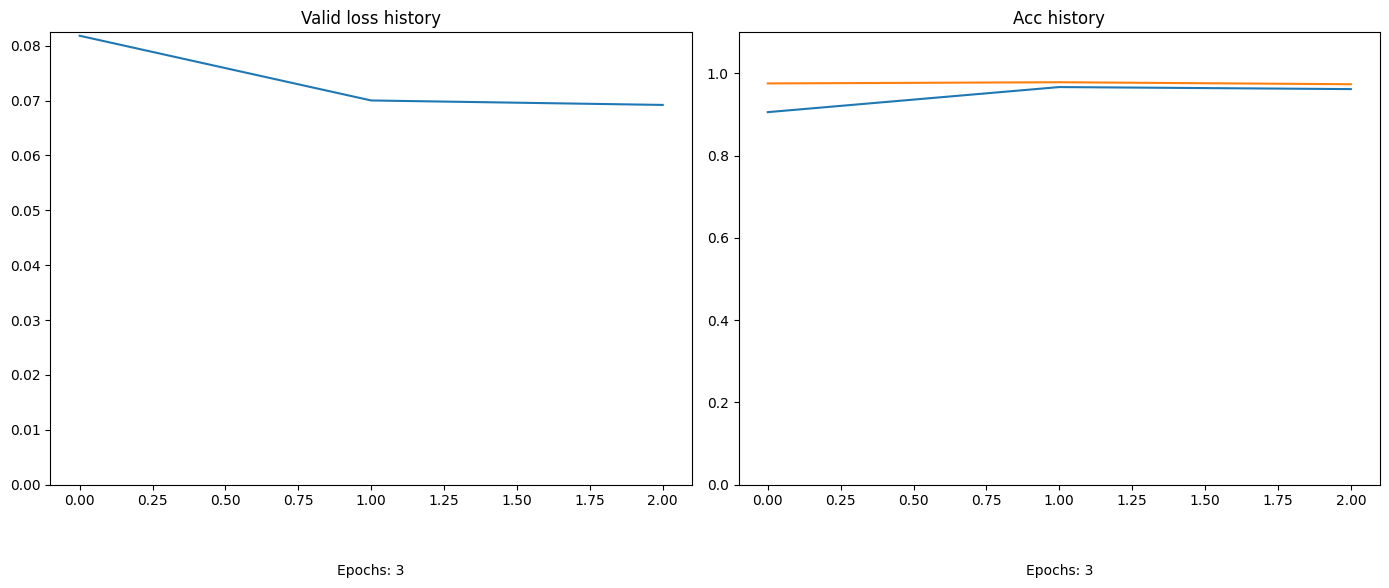

In [40]:
# обучаем модель
model.to(device)
train_epoch_acc = []
train_epoch_losses = []
valid_epoch_losses = []
valid_epoch_acc = []

for epoch in range(3):
    model.train()
    loss_batch = []
    acc_batch  = []

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)

        loss = criterion(preds.squeeze(-1), labels.float())

        loss_batch.append(loss.item())
        acc_batch.append(compute_batch_accuracy(preds, labels))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_epoch_losses.append(np.mean(loss_batch))
    train_epoch_acc.append(np.mean(acc_batch))

    model.eval()
    loss_batch = []
    acc_batch  = []
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        loss = criterion(preds.squeeze(-1), labels.float())

        loss_batch.append(loss.item())
        acc_batch.append(compute_batch_accuracy(preds, labels))

    valid_epoch_losses.append(np.mean(loss_batch))
    valid_epoch_acc.append(np.mean(acc_batch))

    print(f'Epoch train: {epoch+1:02}, accuracy: {train_epoch_acc[-1]:.3f}, loss: {train_epoch_losses[-1]:.3f}')
    print(f'Epoch valid: {epoch+1:02}, accuracy: {valid_epoch_acc[-1]:.3f}, loss: {valid_epoch_losses[-1]:.3f}')

# Отображение графиков
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# plt.subplots_adjust(hspace=0.5)


# Первый график - функция потерь (loss)
ax[0].plot(valid_epoch_losses)
ax[0].set_ylim((0, np.max(train_epoch_losses.extend(valid_epoch_losses))))
ax[0].set_title('Valid loss history')
ax[0].text(0.5, -0.2, f'Epochs: {len(valid_epoch_losses)}', transform=ax[0].transAxes, ha='center')

# Второй график - точность (accuracy)
ax[1].plot(train_epoch_acc)
ax[1].plot(valid_epoch_acc)
ax[1].set_ylim(0, 1.1)
ax[1].set_title('Acc history')
ax[1].text(0.5, -0.2, f'Epochs: {len(train_epoch_acc)}', transform=ax[1].transAxes, ha='center')

plt.tight_layout()
plt.show()

In [41]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
# Создание объекта Resize из модуля torchvision.transforms для изменения размера изображений.
# Аргумент (224, 224) определяет новый желаемый размер изображения, где первое значение - ширина, а второе - высота.
resize = T.Resize((224, 224))


In [43]:
# Чтение изображения с помощью функции read_image из модуля io модуля torchvision.
# Перед чтением изображения, путь к нему указывается в аргументе '/Users/sergey/Downloads/images.jpeg'.
# Затем, результат чтения изображения делится на 255 для нормализации значений пикселей в диапазон от 0 до 1.
# Изменение размера изображения с использованием объекта resize, созданного ранее.
img = resize(io.read_image('/Users/sergey/Downloads/cat.jpeg') / 255)


(-0.5, 223.5, 223.5, -0.5)

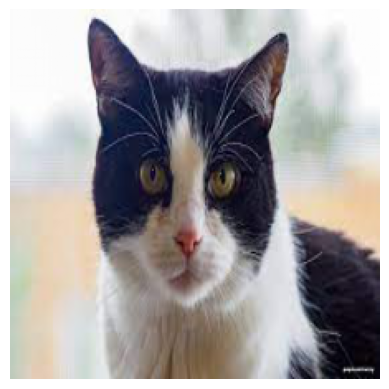

In [44]:
# выводим загруженное изображение
plt.imshow(torch.permute(img, (1,2,0)))
plt.axis('off')

Это кот!: 0.00035627756733447313


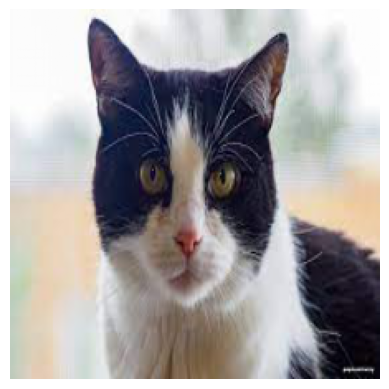

In [45]:
# Отображение изображения с помощью функции imshow из модуля pyplot модуля matplotlib.
# Используется функция permute для перестановки размерностей тензора img и изменения порядка осей на (1, 2, 0).
plt.imshow(torch.permute(img, (1, 2, 0)))

# Установка отключения осей координат на графике.
plt.axis('off')

# Прогнозирование класса изображения с использованием модели model.
# Перед прогнозированием, изображение img конвертируется в тензор и перемещается на устройство device.
# Затем к тензору применяются операции sigmoid() и item() для получения числового значения вероятности предсказания.
prediction = model(img.to(device).unsqueeze(0)).sigmoid().item()

# Если вероятность предсказания больше 0.5, то метка класса устанавливается как "Это собака с вероятностью".
# В противном случае, метка класса устанавливается как "Это кот!".
if prediction > 0.5:
    label = "Это собака с вероятностью"
else:
    label = "Это кот!"

# Вывод метки класса и вероятности предсказания на экран.
print(f"{label}: {prediction}")

# Отображение графика с использованием функции show из модуля pyplot.
plt.show()


In [20]:
# Сохранение состояния модели в файл 'model_weights.pth' с использованием функции save из модуля torch.
# Сохранение весов модели
torch.save(model.state_dict(), "resnet18_weights.pth")



In [22]:
import torchvision.models as models

# Создание экземпляра модели ResNet-18
model = resnet18()

# Загрузка весов модели, которые вы обучили
model.load_state_dict(torch.load('/Users/sergey/ds_bootcamp/ds-phase-2/08-nn/nn_project/resnet18_weights.pth'))

# Сохранение весов модели
# save_path = '/Users/sergey/ds_bootcamp/ds-phase-0/Telegramm_bot _2/model_weights.pth'

# torch.save(model.state_dict(), save_path)


RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([1, 512]) from checkpoint, the shape in current model is torch.Size([1000, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([1000]).